In [2]:
import pandas as pd
from pymongo import MongoClient
import pprint as pp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
# from nltk import word_tokenize, sent_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk import pos_tag


class startProj():

    def mongodbConnection(collectionName):
        # sudo service mongod status
        if collectionName == None:
            print("CollectionName Error")
            exit(0)

        client = MongoClient('mongodb://localhost:27017/')
        db = client.crowdtangle
        return db[collectionName]


    def getDocumentsCollection(self, collectionName): # array of jsons [{},{}]
        # print("Getting documents from: " + collectionName)
        collection = startProj.mongodbConnection(collectionName)

        # https://pymongo.readthedocs.io/en/stable/tutorial.html
        # pp.pprint(collection.count_documents({}))
        return collection.find({},{
            'platform':1,
            'type':1,
            'subscriberCount':1,
            'score':1,
            # 'statistics.actual.likeCount':1,
            # 'statistics.actual.shareCount':1,
            # 'statistics.actual.commentCount':1,
            # 'statistics.actual.loveCount':1,
            # 'statistics.actual.wowCount':1,
            # 'statistics.actual.hahaCount':1,
            # 'statistics.actual.sadCount':1,
            # 'statistics.actual.angryCount':1,
            # 'statistics.actual.thankfulCount':1,
            # 'statistics.actual.careCount':1,
            # 'statistics.expected.likeCount':1,
            # 'statistics.expected.shareCount':1,
            # 'statistics.expected.commentCount':1,
            # 'statistics.expected.loveCount':1,
            # 'statistics.expected.wowCount':1,
            # 'statistics.expected.hahaCount':1,
            # 'statistics.expected.sadCount':1,
            # 'statistics.expected.angryCount':1,
            # 'statistics.expected.thankfulCount':1,
            # 'statistics.expected.careCount':1,
            'account.id':1,
            # 'account.name':1,
            # 'account.subscriberCount':1,
            # 'account.pageCategory':1,
            # 'account.url':1,
        })


    def getDocumentsAccount(self, collectionName): # array of jsons [{},{}]
        # print("Getting documents from: " + collectionName)
        collection = startProj.mongodbConnection(collectionName)

        return collection.find({},{
            'account.id':1,
            'account.name':1,
            'account.subscriberCount':1,
            'account.pageCategory':1,
            'account.url':1,
        })

    def countDocuments(self, collectionName): # array of jsons [{},{}]
        # print("Counting documents from: " + collectionName)
        collection = startProj.mongodbConnection(collectionName)
        return collection.count_documents({})


    def addNodeAttributes(self, G, collectionName, df):
        platform = dict(df.groupby(["platform"])["platform"].count())
        type = dict(df.groupby(["type"])["type"].count())

        for k, v in platform.items():
            platform[k] = float(v)

        for k, v in type.items():
            type[k] = float(v)

        # nx.set_node_attributes(G, {collectionName: {"platform": platform}})
        # nx.set_node_attributes(G, {collectionName: {"type": type}})
        nx.set_node_attributes(G, {collectionName: {"meanSubscriberCount": round(df["subscriberCount"].mean(),2)}})
        nx.set_node_attributes(G, {collectionName: {"meanScore": round(df["score"].mean(),2)}})
        nx.set_node_attributes(G, {collectionName: {"medianSubscriberCount": round(df["subscriberCount"].median(),2)}})
        nx.set_node_attributes(G, {collectionName: {"medianScore": round(df["score"].median(),2)}})

        return G


startproj = startProj()

Total collections: 396
Total documents: 31750


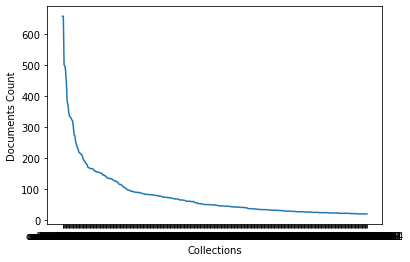

Collections out of graph:
	Total documents of collection0017: 1277521
	Total documents of collection0002: 948915
	Total documents of collection2012: 446275
	Total documents of collection2304: 97492
	Total documents of collection1378: 70922
Total collections: 401
Total documents: 2872875


In [2]:
dfCsv = pd.read_csv('URLs/retweeted_urls_rph_BRA.csv')
collections = {}
outGraph = {}
totalDocuments = 0

for index,row in dfCsv.iterrows():
    collectionName = row['collection_name'].replace("_","")
    # print("\nCollectionName: "+ str(collectionName))
    # if collectionName in ["collection0002","collection0017"]:
    #     continue

    qtdDocuments = startproj.countDocuments(row['collection_name'])

    # Top 5 collections are too big
    if qtdDocuments <= 20 or qtdDocuments > 1000:
        if qtdDocuments > 1000:
            outGraph[collectionName] = qtdDocuments
        continue
    
    totalDocuments += qtdDocuments
    
    collections[collectionName] = qtdDocuments

collections = {k: v for k, v in sorted(collections.items(), key=lambda item: item[1], reverse=True)}

# print(collections)
print("Total collections: %s" % (len(collections)))
print("Total documents: %s" % (totalDocuments))

myList = collections.items()
x, y = zip(*myList)
plt.plot(x, y)
plt.xlabel('Collections')
plt.ylabel('Documents Count')
plt.show()

print("Collections out of graph:")
outGraph = {k: v for k, v in sorted(outGraph.items(), key=lambda item: item[1], reverse=True)}
for key,value in outGraph.items():
    print("\tTotal documents of %s: %s" % (key,value))
    collections[key] = value
    totalDocuments += value

print("Total collections: %s" % (len(collections)))
print("Total documents: %s" % (totalDocuments))

In [3]:
# Collection as node
dfCsv = pd.read_csv('URLs/retweeted_urls_rph_BRA.csv')

G = nx.Graph()
collectionsDone = []
collectionsEmpty = []
accounts = {}
edgeCutValue = 6

# Nodes initialization and their attributes, edge using related account ids cross news shares
for index,row in dfCsv.iterrows():
    collectionName = row['collection_name'].replace("_","")
    # print("\nCollectionName: "+ str(collectionName))

    # skip collections
    # if collectionName in ["collection0002","collection0017"]:
    #     continue

    # Collections filtered above
    if collectionName not in collections:
        print("Collection %s with insufficent length" % (collectionName))
        collectionsEmpty.append(collectionName)
        continue

    documents = startproj.getDocumentsCollection(row['collection_name'])
    dfDocuments = pd.json_normalize(list(documents))

    # Add node attributes from csv
    G.add_node(collectionName)
    rph = row['RP(H)']
    nx.set_node_attributes(G, {collectionName: {"retweetedUrl": row['retweeted_url']}})
    nx.set_node_attributes(G, {collectionName: {"rph": rph}})
    nx.set_node_attributes(G, {collectionName: {"retweetsCount": row['retweets_count']}})
    nx.set_node_attributes(G, {collectionName: {"documentsCount": len(dfDocuments)}})

    # Add node attributes from database
    G = startproj.addNodeAttributes(G, collectionName, dfDocuments)

    accounts[collectionName] = dfDocuments["account.id"].unique()
    
    if rph < -0.4:
        rphText = "Esquerda"
    elif rph < 0.3:
        rphText = "Neutro"
    else:
        rphText = "Direita"

    nx.set_node_attributes(G, {collectionName: {"rphText": rphText}})

    for collection in collectionsDone:
        commonElements = list(set(accounts[collection]).intersection(accounts[collectionName]))

        edgeWeight = len(commonElements)
        if edgeWeight >= edgeCutValue:
            G.add_edge(collectionName, collection)
            G.add_edge(collection, collectionName)
            nx.set_edge_attributes(G, {(collectionName, collection): {"weight": edgeWeight}})
            nx.set_edge_attributes(G, {(collection, collectionName): {"weight": edgeWeight}})
            # nx.set_edge_attributes(G, {(collectionName, collection): {"accounts": ",".join(str(v) for v in commonElements)}})

    collectionsDone.append(collectionName)

nx.write_gml(G, "crowdtangleCollections.gml")
print("Graph saved!")

print("Collections empty:")
for collectionEmpty in collectionsEmpty:
    print(collectionEmpty)

Collection collection0009 with insufficent length
Collection collection0012 with insufficent length
Collection collection0018 with insufficent length
Collection collection0023 with insufficent length
Collection collection0026 with insufficent length
Collection collection0027 with insufficent length
Collection collection0031 with insufficent length
Collection collection0033 with insufficent length
Collection collection0035 with insufficent length
Collection collection0042 with insufficent length
Collection collection0049 with insufficent length
Collection collection0050 with insufficent length
Collection collection0051 with insufficent length
Collection collection0053 with insufficent length
Collection collection0057 with insufficent length
Collection collection0059 with insufficent length
Collection collection0060 with insufficent length
Collection collection0065 with insufficent length
Collection collection0066 with insufficent length
Collection collection0067 with insufficent length


In [5]:
# print("Nodes")
# print(G.nodes(data=True))

print("Edges")
# print(G.edges(data=True))

# edges=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
# print(edges)

Edges


In [3]:
# Account as node
dfCsv = pd.read_csv('URLs/retweeted_urls_rph_BRA.csv')

G = nx.Graph()
accountsDone = []
collectionsEmpty = []
accounts = {}
pageIds = {}
collectionMinDocs = 10

# Create account as node and collections as edges
for index,row in dfCsv.iterrows():
    # graphData = {}
    collectionName = row['collection_name'].replace("_","")
    print("\nCollectionName: "+ str(collectionName))

    # skip collections
    if collectionName in ["collection0002","collection0017","collection2012"]:
        continue

    if startproj.countDocuments(row['collection_name']) <= collectionMinDocs:
        print("Collection %s with insufficent length" % (collectionName))
        collectionsEmpty.append(collectionName)
        continue

    documents = startproj.getDocumentsAccount(row['collection_name'])
    dfDocuments = pd.json_normalize(list(documents))

    dfAccounts = dfDocuments[["account.id","account.name","account.pageCategory","account.subscriberCount"]].set_index('account.id')
    dfAccounts = dfAccounts[~dfAccounts.index.duplicated(keep='first')]
    accounts = dfAccounts.T.to_dict('list')

    # print("accountsDone: %s" % len(accountsDone))
    pageIds = list(accounts.keys())
    pageIds.sort()
    # print("pageIds: %s" % len(pageIds))

    pageToInsert = list(set(pageIds) - set(accountsDone))
    # print("pageToInsert: %s" % len(pageToInsert))
    
    # Create new nodes
    for pageId in pageToInsert:
        attr = dfAccounts.loc[pageId]

        G.add_node(pageId)
        nx.set_node_attributes(G, {pageId: {"pageName": accounts[pageId][0]}})
        try:
            # print("subscriberCount: %s" % str(attr["account.subscriberCount"]))
            nx.set_node_attributes(G, {pageId: {"subscriberCount": int(attr["account.subscriberCount"])}})
        except:
            pass
        try: # Some accounts don't have category
            # print("pageCategory: %s" % str(attr["account.pageCategory"]))
            nx.set_node_attributes(G, {pageId: {"pageCategory": str(attr["account.pageCategory"])}})
        except:
            pass
        accountsDone.append(pageId)

    # Create edges between accounts
    for pageIdOrig in pageIds:
        for pageIdDest in pageIds:
            if pageIdOrig < pageIdDest: # include (pageIdOrig == pageIdDest)
                # print(pageIdOrig, pageIdDest)
                edgeWeight = G.get_edge_data(pageIdOrig, pageIdDest, default=0)
                # print("edgeWeight: %s" % edgeWeight)
                if edgeWeight:
                    nx.set_edge_attributes(G, {(pageIdOrig, pageIdDest): {"weight": edgeWeight['weight']+1}})
                else:
                    G.add_edge(pageIdOrig, pageIdDest)
                    nx.set_edge_attributes(G, {(pageIdOrig, pageIdDest): {"weight": 1}})


print("Collections empty:")
for collectionEmpty in collectionsEmpty:
    print(collectionEmpty)


CollectionName: collection0001

CollectionName: collection0002

CollectionName: collection0003

CollectionName: collection0004

CollectionName: collection0005

CollectionName: collection0006

CollectionName: collection0007

CollectionName: collection0008

CollectionName: collection0009
Collection collection0009 with insufficent length

CollectionName: collection0010

CollectionName: collection0011

CollectionName: collection0012
Collection collection0012 with insufficent length

CollectionName: collection0013

CollectionName: collection0014

CollectionName: collection0015

CollectionName: collection0016

CollectionName: collection0017

CollectionName: collection0018

CollectionName: collection0019

CollectionName: collection0020

CollectionName: collection0021

CollectionName: collection0022

CollectionName: collection0023

CollectionName: collection0024

CollectionName: collection0025

CollectionName: collection0026
Collection collection0026 with insufficent length

CollectionName: c

KeyboardInterrupt: 

In [1]:
# nx.draw(G,with_labels=True)
# plt.show()


In [ ]:
# Remove edges according with threshold weight
threshold = 10

to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] <= threshold]
# print(to_remove)
G.remove_edges_from(to_remove)

nx.write_gml(G, "crowdtangleAccounts.gml")
print("Graph saved!")

NameError: name 'G' is not defined

In [ ]:
print("Nodes")
print(G.nodes(data=True))


In [ ]:
print("Edges")
# print(G.edges(data=True))

edges=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
print(edges)